Importing libraries

In [30]:
from utility import *
import cv2
import numpy as np

%reload_ext autoreload
%autoreload 2
%matplotlib inline


Loading the video. 
`rgb` flag defines whether we would like to use RGB images (`True`) or Grayscale images (`False`)

In [31]:
path_to_video = 'video/auto.mov' 
video, fps = load_video(path_to_video, rgb = True)

Loading video/auto.mov


Properties of the video

In [70]:
num_frames, width, height, fps = get_video_info(path_to_video)

The number of frames is: 774
The resolution of the video is: 1080x1920
Frames per second: 154


Extracting an image from the video

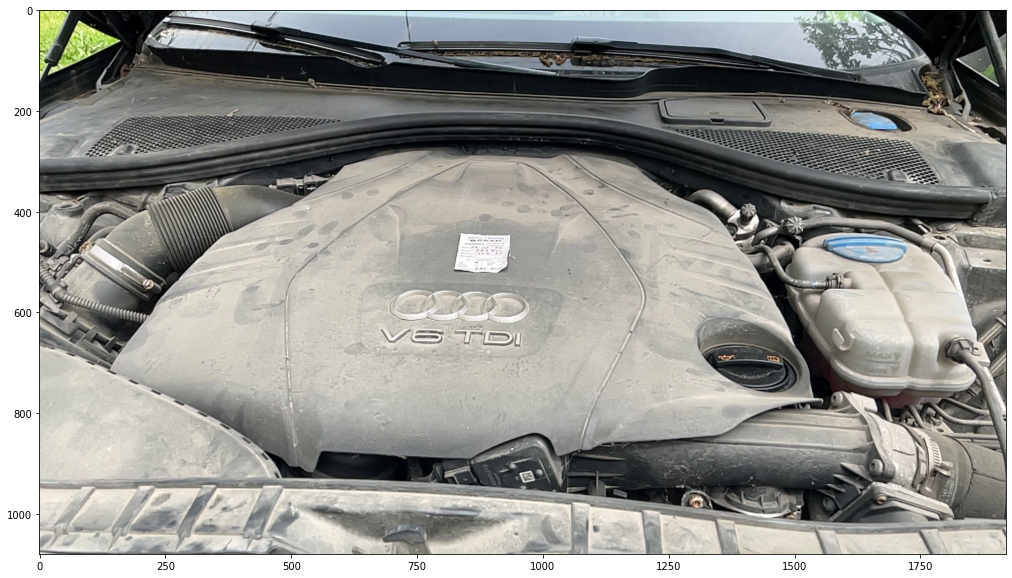

In [32]:
image = video[0].copy()
show_image_nb(image)

Showing layers of Laplacian or Gaussian pyramid.
Laplacian pyramid is used in linear-based approach.

In [ ]:
plot_pyramid(image, pyramid_levels = 4, pyramid = 'laplacian')
#Upper image is originally extracted image, lower image is when histogram equalization is applied (for visualisation purposes)

Choosing a Region Of Interest (ROI)

In [ ]:
square_coords = {'x1':500, 'x2': 900, 'y1':1300, 'y2':1700} 
draw_roi_nb(image, square_coords)

FFT of the image and ROI(This is optional; if you do not want to show ROI fft, set `square_coords=None`)

In [ ]:
show_frequencies(video[:-100], fps, square_coords=square_coords)

#NOTE: sometimes it's better to pass subarray: video[x:y]. The reason is that for some videos
#      the brightness value drops before the video ends so the average of the pixel values looks like the inverse step function, like this: ‾‾‾‾|__
#      so it messes up the fft. For instance, this happens for the 'auto' footage.

Extracting ROI as separate video (optional)

Motion magnification tecniques are memory demanding and the easiest way to go around this issue
 is to crop the video by choosing the ROI and/or to use grayscale images(`rgb=False`) when we load it

In [ ]:
extract_roi_video(video, 'video_results/cropped_video.avi', fps, square_coords)

## Optical flow




#### The grid of motion vectors

`step` determines the distance between the points. `amp` determines how much the length of vectors is going to be amplified (for visualization purposes).

In [29]:
video_input = 'video_results/auto_learning_based.avi'
show_optical_flow_grid(video_input, step=50, amp=2)
#NOTE: press 'Q' to exit

#### Motion vector of specific ROI

When Dense Optical Flow is calculated, the flow is calculated for every pixel in the image.
ROI must be selected over which we *average* the flow! We can select the ROI with the help of `draw_roi_nb` function. 

Loading the video

In [3]:
video_input = "video_results/babyy0.5-1.5Hz_3Levels_20Amp_butterFilter.avi"
video, fps = load_video(video_input, rgb = False)

Loading video_results/babyy0.5-1.5Hz_3Levels_20Amp_butterFilter.avi


Choosing the ROI over which we average the flow

NOTE: By selecting the smaller ROI, we have more precise calculation of the motion vector. This is important if we want to extract the exact motion vector of some small part of the footage.

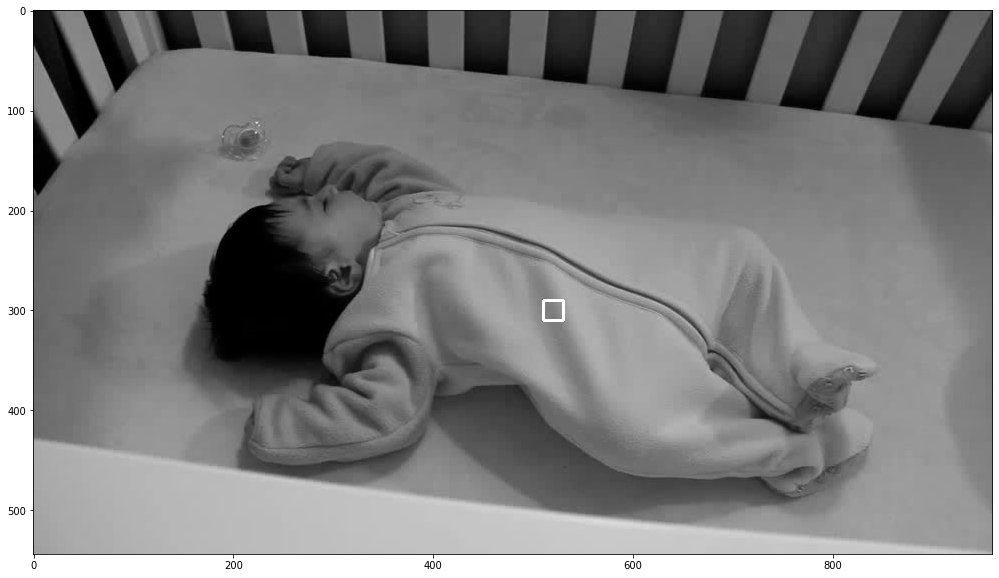

In [80]:
square_coords = {'x1':290, 'x2': 310, 'y1':510, 'y2':530}
draw_roi_nb(video[0].copy(), square_coords)

`base_point` is the base of the vector we draw, it is usually placed in the middle of the ROI.
`amplitude` is the number we multiply the length of the vector for visualization purposes.

In [75]:
base_point = (500, 300)
amplitude = 30

show_optical_flow_roi(video_input, base_point, square_coords, amplitude)
# NOTE: press 'Q' to exit!

#### The colored optical flow visualization

Not really usefull in our case since we have small motions with rapid changes of direction :(
    
But it looks cool

`clip_flow` - clip maximum of flow values, default is `None`. `convert_to_bgr` - cv2 works with BGR

In [28]:
show_optical_flow_color('video_results/auto_learning_based.avi', clip_flow=None, convert_to_bgr=True)
# NOTE: press 'Q' to exit!